# <h1 style="text-align:center;">**Première analyse des données :**</h1>

---

### **Présentation du Projet**

Ce notebook Jupyter définit la méthodologie d'**ingestion**, de **traitement** et d'**enrichissement** des données pour le projet d'alerte de l'ANSSI. L'objectif est de consolider des sources disparates (flux RSS, métriques de menace et référentiels de faiblesses) au sein d'une structure de données unique et exploitable pour notre application de cybersécurité.

### **Méthodologie d'Approche**

Le workflow se décompose en trois phases critiques :

1. **Collecte et Transformation Initiales** :
* Récupération des bulletins de sécurité via le **flux RSS de l'ANSSI**.
* Structuration des données brutes dans un premier DataFrame **Pandas**.


2. **Enrichissement par API (Vecteur de Menace)** :
* Extraction des identifiants **CVE** (Common Vulnerabilities and Exposures).
* Appels API pour intégrer les scores **EPSS** (Exploit Prediction Scoring System), permettant de mesurer la probabilité réelle d'exploitation des failles.


3. **Consolidation Métier (Référentiel MITRE)** :
* Interrogation de l'**API MITRE** pour récupérer les métadonnées contextuelles (descriptions, types de faiblesses CWE).
* Création d'un second DataFrame normalisé sur la clé primaire `CVE`.



### **Résultat Attendu**

Le processus se conclut par la **jointure (merge)** des deux jeux de données. Nous obtenons un DataFrame final enrichi, offrant une vue à 360° sur chaque alerte : de sa publication officielle à son score de dangerosité technique, constituant ainsi le moteur de données de notre application.

---

In [1]:
import feedparser # Pour récupérer les données d'un flux RSS
import numpy as np
import pandas as pd
import time
import datetime
import requests # Pour faire des requêtes API
import re

# **I - Récupération des données ANSSI :**
L'ANSSI rédige des alertes et avis sur des failles de sécurité. Ainsi,nous récupérons le flux RSS sous forme d'un parsefeeddict:

In [2]:
anssi_feed = feedparser.parse("https://www.cert.ssi.gouv.fr/feed/")

Les données sont sous forme de liste dans la clef "entries". Prenons le temps de regarder sous quelle forme les données se présentent.

In [3]:
if anssi_feed.entries:
    for k,v in anssi_feed.entries[1].items():
        print(f"[{k} | {type(v)}] -> {v}", end = "\n")

[title | <class 'str'>] -> Multiples vulnérabilités dans Google Chrome (11 décembre 2025)
[title_detail | <class 'feedparser.util.FeedParserDict'>] -> {'type': 'text/plain', 'language': None, 'base': 'https://www.cert.ssi.gouv.fr/feed/', 'value': 'Multiples vulnérabilités dans Google Chrome (11 décembre 2025)'}
[links | <class 'list'>] -> [{'rel': 'alternate', 'type': 'text/html', 'href': 'https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-1096/'}]
[link | <class 'str'>] -> https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-1096/
[summary | <class 'str'>] -> De multiples vulnérabilités ont été découvertes dans Google Chrome. Elles permettent à un attaquant de provoquer un problème de sécurité non spécifié par l'éditeur.
[summary_detail | <class 'feedparser.util.FeedParserDict'>] -> {'type': 'text/html', 'language': None, 'base': 'https://www.cert.ssi.gouv.fr/feed/', 'value': "De multiples vulnérabilités ont été découvertes dans Google Chrome. Elles permettent à un attaquant de provoquer 

Pour résumer, le feed RSS nous renvoie :
| Élément | Type | Description |
| --- | --- | --- |
| **`title`** | `str` | Le titre de l'alerte. Ici, il contient le nom du produit et la date de publication initiale. |
| **`title_detail`** | `dict` | Contient des métadonnées sur le titre : son format (`text/plain`), la langue et l'URL source (`base`). |
| **`links`** | `list` | Une liste de dictionnaires contenant les liens associés. On y trouve souvent le lien vers la page HTML officielle. |
| **`link`** | `str` | L'URL directe vers l'alerte sur le site du CERT-FR (raccourci du premier lien dans `links`). |
| **`summary`** | `str` | Un résumé textuel (souvent avec du HTML). |
| **`summary_detail`** | `dict` | Détails techniques du résumé. |
| **`id`** | `str` | L'identifiant unique de l'entrée (souvent identique à l'URL). |
| **`guidislink`** | `bool` | Indique si l'identifiant (`id`) est un lien URL utilisable. |
| **`published`** | `str` | La date de publication au format texte. |
| **`published_parsed`** | `struct` | La date convertie en objet `time.struct_time`, ce qui permet de trier les CVE par année ou par mois facilement. |

---

Certaines données nous sont inutiles. Par exemple: `summary`, `isguidislink`, `id` et `links` ne nous interesse pas. Pour le cas de `title_detail` et `summary_detail`, nous allons reformater la forme des données pour garder seulement ce qui est pertinent.

In [4]:
for i in range(len(anssi_feed.entries)):
    # Certaines données sont stocké dans des sous listes ou sous dictionnaires, nous récupérons seulement une partie de ces données
    if "title_detail" in anssi_feed.entries[i] and type(anssi_feed.entries[i]["title_detail"]) == feedparser.util.FeedParserDict:
        anssi_feed.entries[i]["title"] = anssi_feed.entries[i]["title_detail"]["value"]

    if "summary_detail" in anssi_feed.entries[i] and type(anssi_feed.entries[i]["summary_detail"]) == feedparser.util.FeedParserDict:
        anssi_feed.entries[i]["summary_detail"] = anssi_feed.entries[i]["summary_detail"]["value"]

    if "published_parsed" in anssi_feed.entries[i]:
        anssi_feed.entries[i]["published"] = pd.to_datetime(datetime.datetime.fromtimestamp(time.mktime(anssi_feed.entries[i]["published_parsed"]))) # Transformation de la date en format datetime
        del anssi_feed.entries[i]["published_parsed"] # Nous préférons garder seulement la date en type datime et garder comme nom de clé published

    # On supprime ce dont nous n'avons par besoin:
    if "summary" in anssi_feed.entries[i]:
        del anssi_feed.entries[i]["summary"]
    if "id" in anssi_feed.entries[i]:
        del anssi_feed.entries[i]["id"]
    if "guidislink" in anssi_feed.entries[i]:
        del anssi_feed.entries[i]["guidislink"]
    if "title_detail" in anssi_feed.entries[i]:
        del anssi_feed.entries[i]["title_detail"]
    if "links" in anssi_feed.entries[i]:
        del anssi_feed.entries[i]["links"]

Nous pouvons désormais passer ces données dans un dataframe que nous trions par date de publication (du plus récent au plus ancien). Le plus récent est l'index le plus grand.

In [5]:
anssi_df = pd.DataFrame.from_dict(anssi_feed.entries)
anssi_df.sort_index(ascending=False)

,title,link,summary_detail,published
39,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26
38,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26
37,Multiples vulnérabilités dans les produits IBM...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26
36,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26
35,Multiples vulnérabilités dans VMware Tanzu Pla...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26
34,Bulletin d'actualité CERTFR-2025-ACT-056 (22 d...,https://www.cert.ssi.gouv.fr/actualite/CERTFR-...,Ce bulletin d'actualité du CERT-FR revient sur...,2025-12-22
33,Multiples vulnérabilités dans les produits Ela...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-19
32,Multiples vulnérabilités dans Mozilla Firefox ...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-19
31,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-19
30,Multiples vulnérabilités dans MongoDB Server (...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-19


Il existe deux types de publications ANSSI, les alertes et les avis. Créons une colonne qui catégorise les publications en se basant sur le lien.

In [6]:
conditions = [
    anssi_df["link"].str.contains("alerte", case=False, na=False),
    anssi_df["link"].str.contains("avis", case=False, na=False)
]
anssi_df["type_publication"] = np.select(conditions, ["alerte", "avis"], default=None)

anssi_df = anssi_df.dropna(subset=["type_publication"]) # On retire tout ce qui n'est ni un avis, ni une alerte

In [7]:
anssi_df.head()

,title,link,summary_detail,published,type_publication
0,Multiples vulnérabilités dans MISP (08 décembr...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-08,avis
1,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis
2,Multiples vulnérabilités dans les produits IBM...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis
3,Multiples vulnérabilités dans Microsoft Edge (...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis
4,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis


# **II - Récupération du CVE (Common Vulnerabilities and Exposures) :**

Le CVE est un clé unique qui identifie une vulnérabilité. Le flux ANSSI ne fournie pas directement cet identifiant, c'est pourquoi nous allons parcourir la page de chaque alerte/avis pour scrapper les CVEs. 

In [8]:
session = requests.Session() # La création d'une session permet de réduire le temps d'exécution lors de nombreuses requêtes

def get_cve(anssi_url): # La fonction a été optimisée avec Gemini Pro
    if not isinstance(anssi_url, str) or not anssi_url.strip(): # On s'assure de la validité de l'argument d'entrée
        return []

    target_url = anssi_url.rstrip("/") + "/json/" # On récupère le json de la page
    
    try:
        # On utilise la session globale
        response = session.get(target_url, timeout=5) 
        
        if response.status_code == 200: # Si la requête réussie
            # Méthode 1: passer par du REGEX
            # return list(set(re.findall(r"CVE-\d{4}-\d{4,7}", response.text)) )# set() pour dédoubloner, list() pour le format final
        
            # Méthode 2: Passer par la clé cves:
            return [ v["name"] for v in response.json()["cves"] ]
            
    except requests.RequestException: # En cas d'erreur réseau (timeout, 404...), on retourne une liste vide
        print("Rien n'a été trouvé sur ", anssi_url)
        return []
    
    return []

print(anssi_df["link"][0]) # Exemple de lien
print(get_cve(anssi_df["link"][0])) # On teste la fonction pour une alerte ANSSI

https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-1076/
['CVE-2025-67906']


Nous n'avons plus qu'à appliquer cette fonction sur l'ensemble du dataframe pour créer une colonne CVE

In [9]:
anssi_df["cve"] = anssi_df["link"].transform(get_cve) # Renvoie la liste des CVEs

Mais certaines publications n'ont pas de CVE. Cela arrive car parfois l'ANSSI fait des publications pour recommander des pratiques ou d'être vigilant sur certaines choses. Ainsi il n'existe pas de faille référencée avec CVE. Ce n'est pas pour autant qu'il faut les supprimer de notre dataframe.

In [10]:
anssi_df[anssi_df["cve"].str.len() == 0] # Les lignes sans CVE

,title,link,summary_detail,published,type_publication,cve
8,Multiples vulnérabilités dans Roundcube (15 dé...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-15,avis,[]


Il arrive souvent qu'une alerte/avis ANSSI fasse référence de plusieurs CVE, or nous souhaitons à la fin un Dataframe qui donne des informations de chaque faille CVE et non chaque avis/alerte ANSSI.
C'est pourquoi nous allons dépacker ces CVEs pour que chaque CVE ait sa ligne à elle. Ainsi, une alerte CVE pourra être associé à plusieurs CVE.
Pour faire cela, nous utilisons la méthode `explode` des dataframes.

In [11]:
anssi_df = anssi_df.explode("cve")
anssi_df = anssi_df.reset_index(drop=True) # On reset les index car explode "duplique" les index. L'argument drop supprime l'ancien index

Voici les 5 premiers éléments du dataframe des alertes ANSSI.

In [12]:
anssi_df.head()

,title,link,summary_detail,published,type_publication,cve
0,Multiples vulnérabilités dans MISP (08 décembr...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-08,avis,CVE-2025-67906
1,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14372
2,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14373
3,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14174
4,Multiples vulnérabilités dans les produits IBM...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis,CVE-2022-50367


# **III - Enrichissement du dataframe ANSSI par le score EPSS avec l'API EPSS :**
Le score EPSS représente la probabilité qu'une faille soit exploitée.

In [13]:
epss_api_url = "https://api.first.org/data/v1/epss?cve=" 

def get_epss_data(cve):    
    target_url = epss_api_url + cve
    
    try:
        res = session.get(target_url, timeout=5)

        if res.status_code != 200:
            print(res.status_code)
            return {}

        data = res.json()
        
        epss_data = data.get("data", [])

        if epss_data != []:
            return float(epss_data[0]["epss"]) or np.nan

        return np.nan
    except Exception:
        print("Rien n'a été trouvé pour ", cve)
        return np.nan

print(anssi_df["cve"][0]) # Un identifiant CVE
print(get_epss_data(anssi_df["cve"][0])) # On teste la fonction pour 1 CVE

CVE-2025-67906
0.00035


In [14]:
anssi_df["epss_score"] = anssi_df["cve"].transform(lambda x: get_epss_data(x) if (pd.notna(x)) else np.nan) # On applique la fonction seulement dans le cas où le CVE n'est pas nul

In [15]:
anssi_df.head()

,title,link,summary_detail,published,type_publication,cve,epss_score
0,Multiples vulnérabilités dans MISP (08 décembr...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-08,avis,CVE-2025-67906,0.00035
1,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14372,0.00040
2,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14373,0.00030
3,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14174,0.00530
4,Multiples vulnérabilités dans les produits IBM...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis,CVE-2022-50367,0.00016


# **IV - Récupération des données MITRE :**
Nous allons créer un deuxième dataframe comportant toutes les données fournies par l'API Mitre.

En s'intéressant de plus près au fonctionnement du système Mitre et de son [API](https://cveawg.mitre.org/api-docs/), nous avons découvert qu'il existe 3 états pour un CVE:
| État | Définition |
| :--- | :--- |
| **`RESERVED (Réservé)`** | Un numéro CVE a été attribué à une organisation (un éditeur ou un chercheur), mais les détails de la faille ne sont pas encore publics. |
| **`PUBLISHED (Publié)`** | La vulnérabilité est officielle, les détails techniques sont disponibles et le processus d'analyse est terminé (ou en cours). |
| **`REJECTED (Rejeté)`** | Le CVE a été annulé. Cela arrive si la faille était un doublon d'une autre, s'il s'agissait d'une erreur de signalement, ou si la vulnérabilité n'en était finalement pas une. |

L'API `https://cveawg.mitre.org/api/cve/{CVE}` de Mitre renvoie l'état du CVE si le CVE n'est pas réservé. Si il est réservé, le call renvoie une erreur 404 (Page not found).

Il est possible de s'assurer l'état du CVE lors d'une réponse 404 avec `https://cveawg.mitre.org/api/cve-id/{CVE}`. Voici un [exemple](https://cveawg.mitre.org/api/cve-id/CVE-2025-58085).
Cependant, nous n'allons pas faire ces calls à des fins de performances et car nous avons déjà la certitude de pouvoir filtrer les CVE rejeté et réservé.
Nous enlevons tout ceux rejeté car ils ne sont plus d'actualité et tout ceux réservé car nous n'avons aucune information sur la faille, donc rien à signaler à notre utilisateur final.

In [16]:
mitre_api_url = "https://cveawg.mitre.org/api/cve/"

def get_mitre_data(cve):
    if pd.isna(cve):
        return {}
    
    target_url = mitre_api_url + cve
    
    try:
        res = session.get(target_url, timeout=5)
        if res.status_code != 200:
            print(f"[ERROR-{res.status_code}] {cve}")

            return {}

        data = res.json()

        # On vérifie l'état du CVE
        cveMetadata = data.get("cveMetadata", {})
        if cveMetadata != {}:
            if cveMetadata["state"] != "PUBLISHED": # Si il n'est pas publié, on l'ignore
                return {}

        cna = data.get("containers", {}).get("cna", {})
        
        # Extraction sécurisée de la description
        descriptions = cna.get("descriptions", [])
        desc = descriptions[0].get("value", None) if descriptions else None

        # Extraction sécurisée du CWE
        problem_types = cna.get("problemTypes", [])
        cwe_id = np.nan
        cwe_desc = np.nan
        
        if problem_types:
            # On prend souvent le premier type de problème listé
            desc_list = problem_types[0].get("descriptions", [])
            if desc_list:
                cwe_id = desc_list[0].get("cweId", np.nan)
                cwe_desc = desc_list[0].get("description", np.nan)

        metrics = cna.get("metrics", [])
        cvss_score = None
        if metrics != []:
            metrics = metrics[0]
            for k in metrics.keys():
                if "cvss" in k.lower():
                    cvss_score = float(metrics[k]["baseScore"])
                    break

        # Construction du dictionnaire final
        return {
            "cve": cve,
            "cwe": cwe_id,
            "cwe_desc": cwe_desc,
            "cvss_score": cvss_score,
            "mitre_desc": desc,
            "affected_product": [ # Par méthode de compréhension en liste
                {
                    "vendor": prod.get("vendor"),
                    "product": prod.get("product"),
                    "versions": [v.get("version") for v in prod.get("versions", []) if v.get("status") == "affected"]
                }
                for prod in cna.get("affected", [])
            ]
        }
    except Exception:
        return {}

print(anssi_df["cve"][3])
print(get_mitre_data(anssi_df["cve"][3]))

CVE-2025-14174
{'cve': 'CVE-2025-14174', 'cwe': nan, 'cwe_desc': 'Out of bounds memory access', 'cvss_score': None, 'mitre_desc': 'Out of bounds memory access in ANGLE in Google Chrome on Mac prior to 143.0.7499.110 allowed a remote attacker to perform out of bounds memory access via a crafted HTML page. (Chromium security severity: High)', 'affected_product': [{'vendor': 'Google', 'product': 'Chrome', 'versions': ['143.0.7499.110']}]}


In [17]:
# Version singlethread
# mitre_data = [ get_mitre_data(cve) for cve in anssi_df["cve"] ] # Cette exécution prend du temps car elle fait des requêtes pour chaque ligne du df

In [18]:
"""
C'est du multithread qu'on ne gardera pas dans la version finale du notebook car c'est pas le lieu pour ça.
"""

# Version multithread

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # Pour voir la barre de progression

# 1. On récupère la liste des CVE uniques pour éviter les appels inutiles
liste_cves = anssi_df['cve'].unique().tolist()

# 2. Configuration du nombre de threads (ex: 10 à 20)
# Trop de threads peut causer un blocage de l'API (Rate Limiting)
MAX_WORKERS = 15 

print(f"Récupération de {len(liste_cves)} CVEs en cours...")

# 3. Exécution parallèle
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # On utilise tqdm pour suivre l'avancement
    mitre_data = list(tqdm(executor.map(get_mitre_data, liste_cves), total=len(liste_cves)))



Récupération de 1049 CVEs en cours...


  4%|▍         | 41/1049 [00:01<00:25, 39.87it/s]

[ERROR-404] CVE-2025-9615


 11%|█         | 113/1049 [00:01<00:08, 105.37it/s]

[ERROR-404] CVE-2025-67848
[ERROR-404] CVE-2025-67852
[ERROR-404] CVE-2025-67850
[ERROR-404] CVE-2025-67849
[ERROR-404] CVE-2025-67851
[ERROR-404] CVE-2025-67853
[ERROR-404] CVE-2025-67856
[ERROR-404] CVE-2025-67855
[ERROR-404] CVE-2025-67854
[ERROR-404] CVE-2025-67857
[ERROR-404] CVE-2025-14713
[ERROR-404] CVE-2025-66593
[ERROR-404] CVE-2025-66592
[ERROR-404] CVE-2025-14177
[ERROR-404] CVE-2025-14180
[ERROR-404] CVE-2025-14178


 29%|██▊       | 301/1049 [00:02<00:04, 183.96it/s]

[ERROR-404] CVE-2025-33134


 37%|███▋      | 383/1049 [00:03<00:03, 181.55it/s]

[ERROR-404] CVE-2025-59488
[ERROR-404] CVE-2025-57779
[ERROR-404] CVE-2025-58085


100%|██████████| 1049/1049 [00:07<00:00, 146.49it/s]

[ERROR-404] CVE-2023-43020


In [19]:
mitre_df = pd.DataFrame(mitre_data) # On transforme nos données en df 
mitre_df = mitre_df.dropna(subset=['cve']) # Cette ligne supprime les CVE rejeté et réservé
mitre_df = mitre_df.reset_index(drop=True)

mitre_df.head() # On affiche les 5 premières lignes

,cve,cwe,cwe_desc,cvss_score,mitre_desc,affected_product
0,CVE-2025-67906,CWE-79,CWE-79 Improper Neutralization of Input During...,5.4,"In MISP before 2.5.28, app/View/Elements/Workf...","[{'vendor': 'MISP', 'product': 'MISP', 'versio..."
1,CVE-2025-14372,CWE-416,Use after free,NaN,Use after free in Password Manager in Google C...,"[{'vendor': 'Google', 'product': 'Chrome', 've..."
2,CVE-2025-14373,NaN,Inappropriate implementation,NaN,Inappropriate implementation in Toolbar in Goo...,"[{'vendor': 'Google', 'product': 'Chrome', 've..."
3,CVE-2025-14174,NaN,Out of bounds memory access,NaN,Out of bounds memory access in ANGLE in Google...,"[{'vendor': 'Google', 'product': 'Chrome', 've..."
4,CVE-2022-50367,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers..."


En ayant procédé par de cet manière, il ne reste dans notre df que les CVE publiés qui représentent une réelle menace. 

# **V - Création de la base de donnée des alertes :**
Désormais, nous avons toutes les informations pour créer le DataFrame final avec toutes les informations nécessaire à notre application. Voici la structure du dataframe que nous souhaitons:

| Nom de la colonne | Définition & Détails |
| :--- | :--- |
| **`anssi_title`** | Titre de l'alerte/avis ANSSI |
| **`anssi_link`** | Lien de l'alerte/avis ANSSI |
| **`anssi_desc`** | Description de l'alerte/avis ANSSI |
| **`anssi_published`** | Date de publication de l'alerte/avis ANSSI |
| **`cve`** | Identifiant unique de la table, numéro unique qui réfère à la faille |
| **`epss_score`** | Score EPSS, Probabilité que la faille soit exploitée |
| **`cwe`** | Le CWE (Common Weakness Enumeration) est un système de classification universel qui répertorie les faiblesses de sécurité dans les logiciels et le matériel informatique. |
| **`cwe_desc`** | Description CWE |
| **`cvss_score`** | Score CVSS, gravité de la faille |
| **`mitre_desc`** | Description renvoyé par l'API Mitre |
| **`affected_product`** | Liste de table des produits affecté avec le nom du développeur, le produit affecté et les versions vulnérables |


Nous allons créer ce dataframe en fusionnant mitre_df et anssi_df sur les valeurs des colonnes CVE.

In [20]:
anssi_df.columns = ['anssi_title', 'anssi_link', 'anssi_desc', 'anssi_published', 'type_publication', 'cve', 'epss_score'] # Renommage des noms des colonnes

DB = anssi_df.merge(mitre_df, on='cve', how='left')

In [21]:
def set_severity(cvss_score):
    if pd.isna(cvss_score):
        return np.nan
    
    if cvss_score >= 9:
        return "Critical"
    elif cvss_score >= 7:
        return "High"
    elif cvss_score >= 4:
        return "Medium"
    else:
        return "Low"

DB["base_severity"] = DB["cvss_score"].transform(set_severity)

In [22]:
DB

,anssi_title,anssi_link,anssi_desc,anssi_published,type_publication,cve,epss_score,cwe,cwe_desc,cvss_score,mitre_desc,affected_product,base_severity
0,Multiples vulnérabilités dans MISP (08 décembr...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-08,avis,CVE-2025-67906,0.00035,CWE-79,CWE-79 Improper Neutralization of Input During...,5.4,"In MISP before 2.5.28, app/View/Elements/Workf...","[{'vendor': 'MISP', 'product': 'MISP', 'versio...",Medium
1,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14372,0.00040,CWE-416,Use after free,NaN,Use after free in Password Manager in Google C...,"[{'vendor': 'Google', 'product': 'Chrome', 've...",NaN
2,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14373,0.00030,NaN,Inappropriate implementation,NaN,Inappropriate implementation in Toolbar in Goo...,"[{'vendor': 'Google', 'product': 'Chrome', 've...",NaN
3,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14174,0.00530,NaN,Out of bounds memory access,NaN,Out of bounds memory access in ANGLE in Google...,"[{'vendor': 'Google', 'product': 'Chrome', 've...",NaN
4,Multiples vulnérabilités dans les produits IBM...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis,CVE-2022-50367,0.00016,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26,avis,CVE-2024-53218,0.00038,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers...",NaN
1273,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26,avis,CVE-2024-53090,0.00016,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers...",NaN
1274,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26,avis,CVE-2024-50067,0.00034,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers...",NaN
1275,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26,avis,CVE-2025-39946,0.00021,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers...",NaN


---

# **VI - Interprétation, analyse et visualisation des données :**

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Histogramme de la gravité des failles :

### *a. Mise en forme des résultats:*

Text(0, 0.5, 'Occurrence')

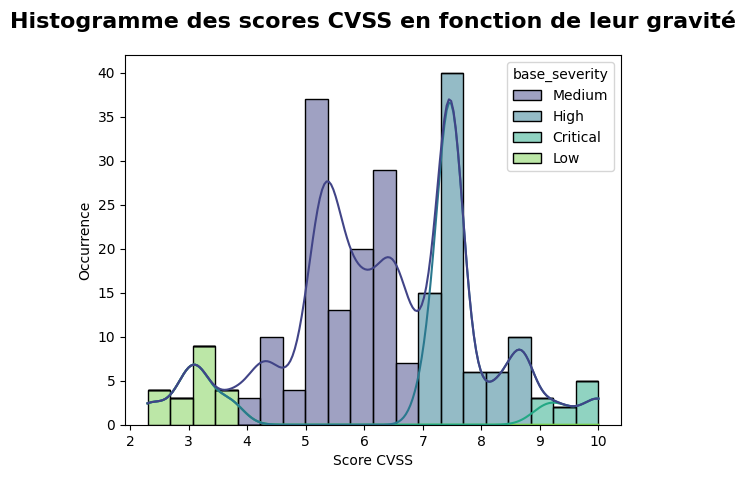

In [24]:
sns.histplot(data=DB, x="cvss_score", hue = "base_severity", 
             palette="viridis", # Palette de couleur
             kde=True, # Kernel Density Estimate (Estimation de la densité par noyau): C'est la tendance des données
             bins=20, # Le nombre de barre verticale
             multiple="stack")
plt.title("Histogramme des scores CVSS en fonction de leur gravité", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Score CVSS")
plt.ylabel("Occurrence")

### *b. Interprétation:*

L'histogramme révèle une distribution multimodale des vulnérabilités, avec une concentration majeure située dans la zone des scores Élevés (7.0 - 9.0). Cela indique que le flux de données analysé est principalement composé de menaces sérieuses nécessitant une remédiation rapide, plutôt que de vulnérabilités mineures. La superposition des couleurs montre une corrélation précise entre le score numérique CVSS et la catégorie de gravité (`base_severity`). La courbe de densité (KDE) confirme cette tendance en isolant nettement trois massifs de risques : un groupe "Moyen" centré sur 5.2, un groupe "Élevé" dominant à 7.5, et un groupe "Critique" isolé à l'extrémité droite.

## 2) Camembert des gravités des failles :

### *a. Préparation des données:*

In [25]:
data2 = DB["base_severity"].value_counts() # On récupère les occurrences de chaque gravité

### *b. Mise en forme des résultats:*

Text(0.5, 1.0, 'Distribution de la gravité des failles :')

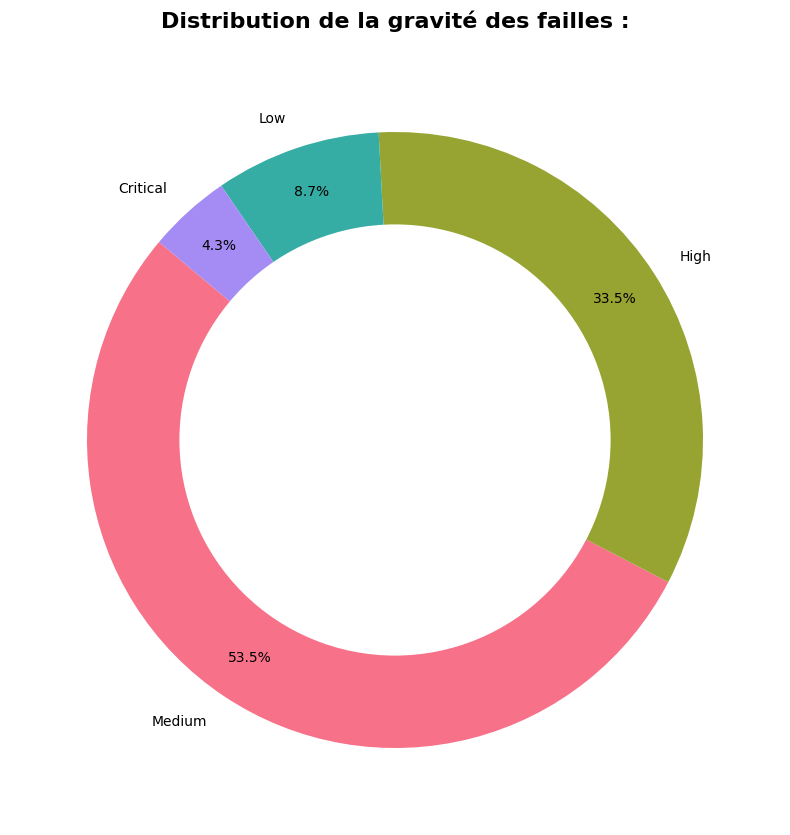

In [26]:
plt.figure(figsize=(10, 10))
colors = sns.color_palette('husl', 4)
plt.pie(data2, labels=data2.index, 
        autopct='%1.1f%%', # On affiche le pourcentage
        pctdistance=0.85, # On éloigne les pourcentages du centre
        startangle=140,
        colors=colors # On change les couleurs par défaut
        )

# (Choix arbitraire esthétique) On ajoute un trou au milieu en créer un cercle blanc pour une visibilité meilleure du camember
centre_cercle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf() # Pour récupérer la figure actuelle
fig.gca().add_artist(centre_cercle) # On ajoute le cercle au camember

plt.title("Distribution de la gravité des failles :", fontsize=16, pad=20, fontweight='bold')

### *c. Interprétation:*

La distribution de la gravité révèle un flux centré sur la dangerosité réelle : plus de 92 % des vulnérabilités publiées ont un impact qualifié de Moyen à Critique. La prédominance des failles "Moyennes" et "Élevées" souligne une activité intense de maintenance préventive, tandis que le segment "Critique" (4,8 %), bien que restreint, représente les menaces immédiates

## 3) Les éditeurs les plus touchés par les failles :

### *a. Préparation des données:*

In [27]:
data3 = DB[["cve", "affected_product", "cwe"]].explode('affected_product') # Le CWE n'est pas utile pour cette partie 3), elle le sera en partie 5)
data3.reset_index(drop=True)

,cve,affected_product,cwe
0,CVE-2025-67906,"{'vendor': 'MISP', 'product': 'MISP', 'version...",CWE-79
1,CVE-2025-14372,"{'vendor': 'Google', 'product': 'Chrome', 'ver...",CWE-416
2,CVE-2025-14373,"{'vendor': 'Google', 'product': 'Chrome', 'ver...",NaN
3,CVE-2025-14174,"{'vendor': 'Google', 'product': 'Chrome', 'ver...",NaN
4,CVE-2022-50367,"{'vendor': 'Linux', 'product': 'Linux', 'versi...",NaN
...,...,...,...
2690,CVE-2024-50067,"{'vendor': 'Linux', 'product': 'Linux', 'versi...",NaN
2691,CVE-2025-39946,"{'vendor': 'Linux', 'product': 'Linux', 'versi...",NaN
2692,CVE-2025-39946,"{'vendor': 'Linux', 'product': 'Linux', 'versi...",NaN
2693,CVE-2024-47691,"{'vendor': 'Linux', 'product': 'Linux', 'versi...",NaN


In [28]:
data3 = data3.dropna(subset=["affected_product"])

# Normalement, aucune ligne n'a de vendor, versions ou product nul donc on se permet d'appliquer ces opérations sans vérifier la nulité des valeurs
data3["vendor"] = data3["affected_product"].apply(lambda x: x["vendor"])
data3["versions"] = data3["affected_product"].apply(lambda x: x["versions"])
data3["product"] = data3["affected_product"].apply(lambda x: x["product"])

data3 = data3[data3["vendor"] != "n/a"] # On retire tous les n/a

top_10_3 = data3["vendor"].value_counts().head(10)


### *b. Mise en forme des résultats:*

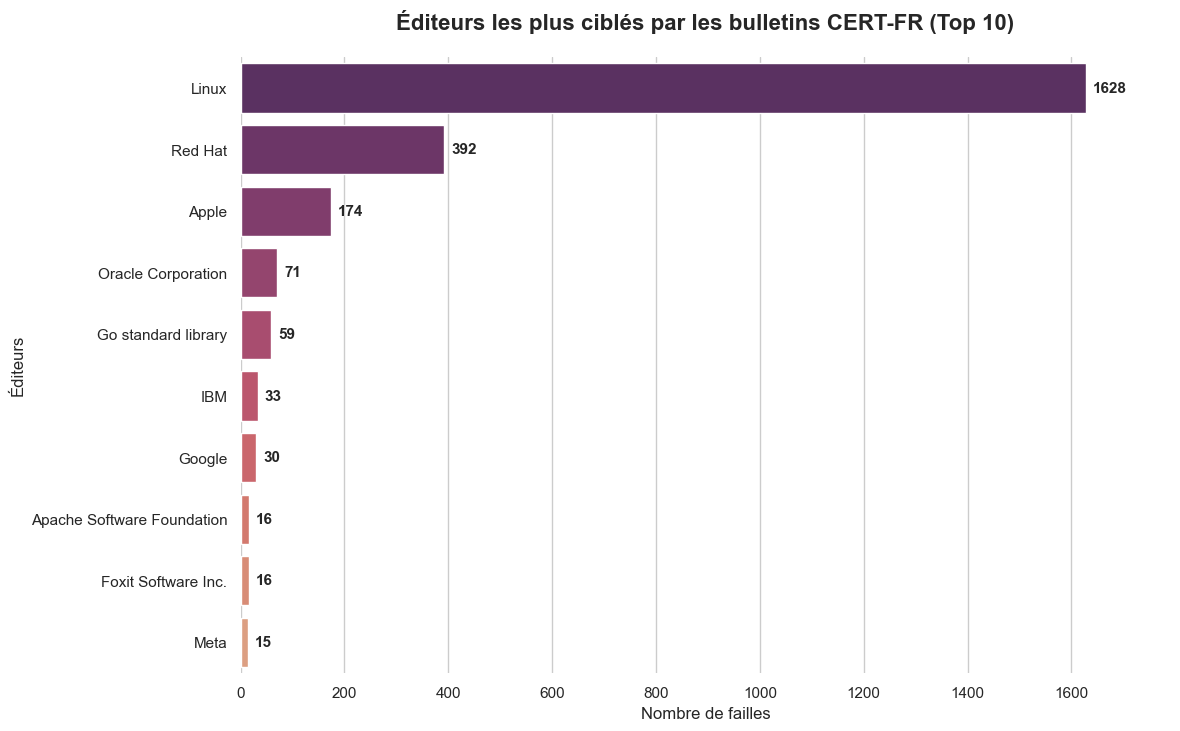

In [29]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid") # Fond propre avec lignes de repère discrètes
ax = sns.barplot(x = top_10_3.values, y=top_10_3.index, palette="flare_r", hue = top_10_3.index)

plt.title("Éditeurs les plus ciblés par les bulletins CERT-FR (Top 10)", fontsize=16, pad=20, fontweight='bold')
plt.ylabel("Éditeurs")
plt.xlabel("Nombre de failles")
sns.despine(left=True, bottom=True) # On supprime le cadre simplement par choix esthétique arbitraire

# Ajout des nombres au bout des barres
plt.xlim(0, top_10_3.values.max() * 1.1)
for container in ax.containers:
    ax.bar_label(container, padding=5, fontweight='bold', fontsize=11)

### *c. Interprétation:*
Le paysage des vulnérabilités CERT-FR est outrageusement dominé par l'écosystème Linux, qui représente à lui seul plus de trois fois le volume de failles de l'éditeur suivant. Cette concentration souligne l'importance vitale du maintien en condition de sécurité (MCS) des environnements serveurs et Open Source, qui constituent la colonne vertébrale des systèmes d'information ciblés par les bulletins de l'ANSSI.

## 4) Types de failles les plus fréquentes :

### *a. Préparation des données:*

In [30]:
data4 = DB[["cwe", "cwe_desc"]]
data4 = data4.dropna(subset=["cwe"]) # On retire toutes les lignes sans CWE

# Ici, on regroupe data par CWE, puis pour chaque élement de CWE_DESC, on compte le nombre de répétition (occurences) et pour la description on prends la première description que l'on trouve dans cwe_desc.
# On procède de cette manière pour obtenir une description précise du CWE.
top_10_4 = data4.groupby('cwe')['cwe_desc'].agg(
    occurences='size', 
    description='first'
)

top_10_4 = top_10_4.sort_values(by='occurences', ascending=False).head(10).reset_index() # On trie les valeurs, puis on prend les 10 CWE les plus fréquent (et on reset l'index mais ça c'est pas réellement utile)

top_10_4['description'] = top_10_4['description'].str.replace(r'^CWE-\d+:?\s*', '', regex=True) # Pour + de clareté, on nettoie les descriiptions pour uniformiser la description choisie
top_10_4['description'] = top_10_4['description'].replace('', 'Description non disponible') # On remplace la description vide par un label

top_10_4["label"] = top_10_4['cwe'] + ": " + top_10_4['description'] # On créer une colonne qui concatène la description et le CWE

### *b. Mise en forme des résultats:*

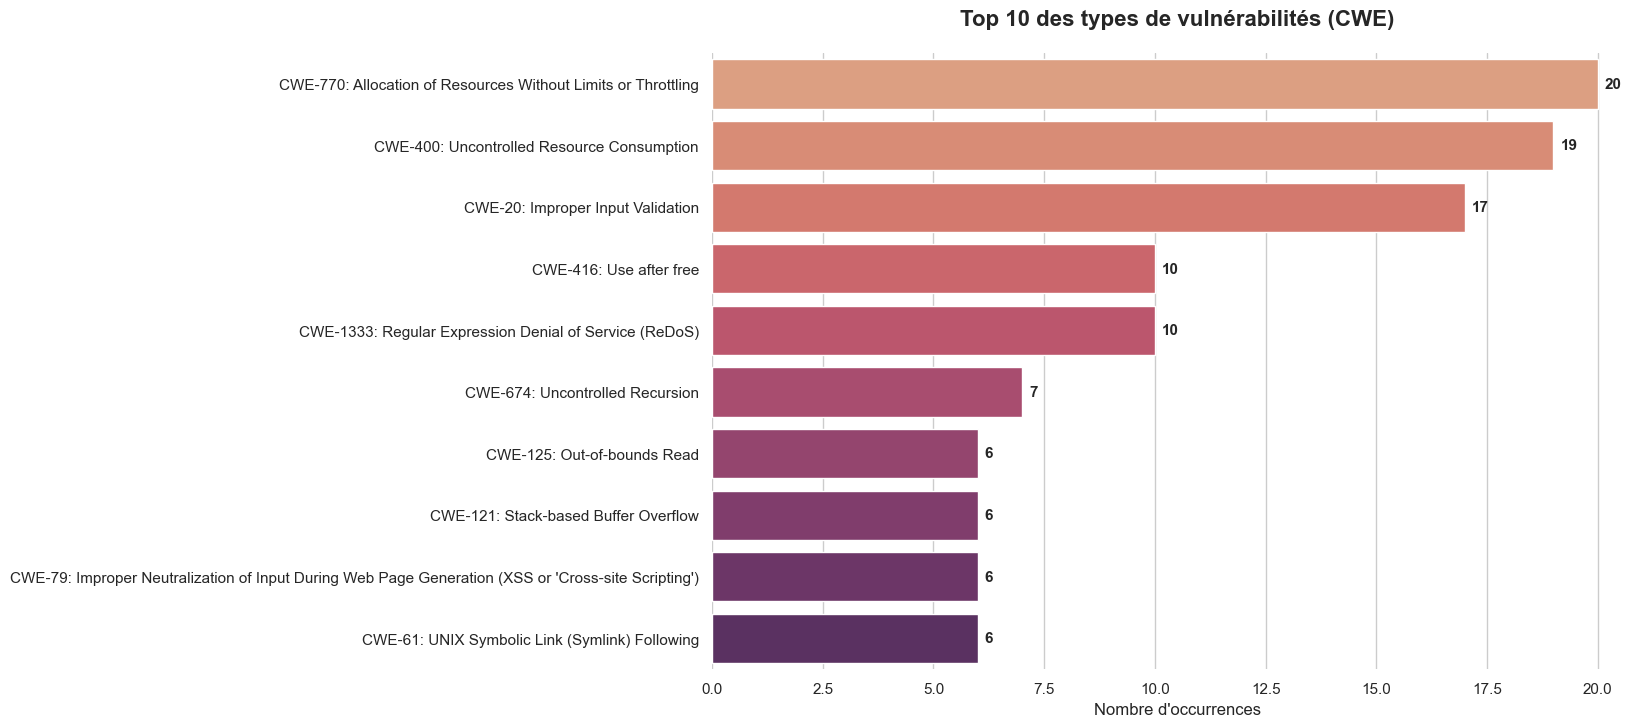

In [31]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=top_10_4,
    x='occurences',
    y='label',
    hue='label',
    palette='flare',
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, padding=5, fontweight='bold', fontsize=11)

plt.title("Top 10 des types de vulnérabilités (CWE)", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Nombre d'occurrences", fontsize=12)
plt.ylabel("") # On masque le label Y qui est redondant
sns.despine(left=True, bottom=True) # On supprime le cadre simplement par choix esthétique arbitraire

### *c. Interprétation:*

**Analyse des Éditeurs : L'omniprésence du socle Open Source**
Le premier graphique montre une concentration extrême sur l'écosystème Linux (Linux + Red Hat cumulés représentent près de 1 900 bulletins).

- Domination de Linux : Avec 1 495 failles, Linux est le sujet principal du CERT-FR. Cela s'explique par sa présence massive dans les infrastructures critiques, les serveurs et le Cloud.

- Le fossé propriétaire/libre : On observe un écart immense entre Linux et des acteurs comme Oracle (50) ou Google (21). Cela suggère que la veille du CERT-FR est fortement orientée vers le "bas niveau" (noyaux et bibliothèques système) plutôt que vers les applications finales.

- Infrastructure vs Apps : La présence de la Go standard library et d'acteurs comme Apache ou Elastic confirme que le risque se situe principalement sur les briques de construction des systèmes d'information.
  
**Analyse des CWE :**
- Le règne du Déni de Service (DoS) : Les deux premières failles (CWE-770 et CWE-400) concernent la gestion des ressources. À elles seules, elles représentent une part majeure des risques. Elles permettent à un attaquant de saturer un système pour le rendre indisponible.

-  Fragilité de la gestion mémoire : La présence de CWE-416 (Use after free), CWE-125 (Out-of-bounds Read) et CWE-121 (Buffer Overflow) est typique des logiciels écrits en C/C++ (comme le noyau Linux). C'est le point faible historique des infrastructures de bas niveau.

- Absence de "Failles Web" classiques : On remarque que le CWE-79 (XSS) est très bas dans le classement (5 occurrences). Cela confirme que les bulletins CERT-FR traitent moins de vulnérabilités applicatives web simples et plus de problèmes de stabilité système.

Ainsi, le paysage de la menace cyber révélé par ces données souligne une hégémonie de l'écosystème Linux dans les bulletins du CERT-FR, où les failles de gestion des ressources (DoS) et de corruption mémoire constituent les vecteurs de risque prioritaires pour la sécurité des infrastructures critiques.

## 5) Matrice de corrélation :

### *a. Préparation des données:*

In [32]:
# On filtre d'abord les données pour ne garder que le top 10 respectif
top_vendors = data3['vendor'].value_counts().head(10).index
top_cwes = data3['cwe'].value_counts().head(10).index

subset = data3[data3['vendor'].isin(top_vendors) & data3['cwe'].isin(top_cwes)]

matrix = pd.crosstab(subset['vendor'], subset['cwe']) # On utilise crosstab pour créer la matrice

### *b. Mise en forme des résultats:*

Text(117.24999999999997, 0.5, '')

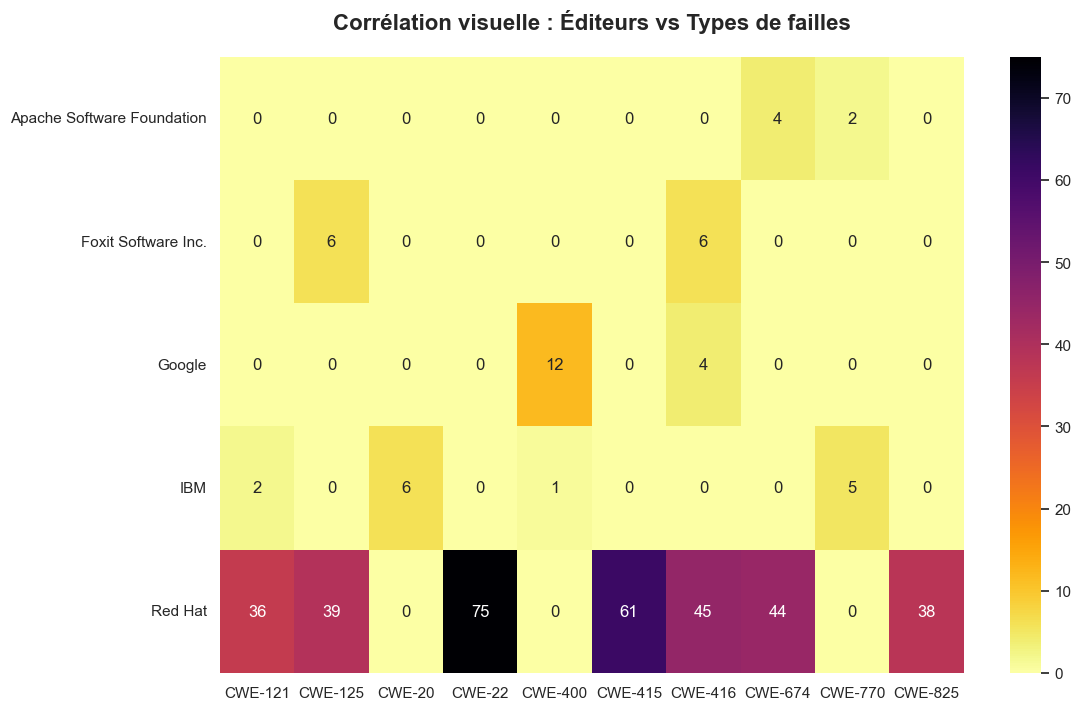

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, annot=True, cmap="inferno_r")
plt.title("Corrélation visuelle : Éditeurs vs Types de failles", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("")
plt.ylabel("")

### *c. Interprétation:*
Nous avons relevé trois observations:

- Priorité de Patching : L'effort de remédiation doit se concentrer sur Red Hat / Linux, qui subit non seulement le plus de bulletins, mais aussi les failles les plus variées techniquement.

- Vecteur de Risque n°1 : La Disponibilité (DoS via ressources) est le risque le plus fréquent, mais la Corruption mémoire est le risque le plus profond (permettant souvent l'exécution de code à distance).

- Observation sur les données : Il est intéressant de noter que la matrice de corrélation affiche des chiffres (ex: 75 pour Red Hat/CWE-22) bien plus élevés que le graphique des occurrences globales. Cela suggère qu'un seul bulletin peut contenir de nombreuses CVE, multipliant ainsi l'impact réel par type de faille.